In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import load_model
from keras.layers import GRU, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt


In [ ]:
DATA_PATH = "D:/Spring_Board/PrognosAI/CMAPSS_Data"
MODEL_PATH = "D:/Spring_Board/PrognosAI/Models"
RUL_CLIP_VALUE = 126
SEQ_LEN = 30

In [3]:
def read_test_data(data_path,dataset_name):
    col_names = (["unit_number", "time","setting_1", "setting_2", "setting_3"] +[f"sensor_{i}" for i in range(1, 22)])
    df_test = pd.read_csv(f"{data_path}/test_{dataset_name}.txt", sep=r"\s+", header=None, names=col_names)
    df_rul = pd.read_csv(f"{data_path}/RUL_{dataset_name}.txt", sep=r"\s+", header=None, names=['RUL'])
    
    return df_test,df_rul


In [4]:
def apply_scaling_to_test(df_unit_history, scale_cols, scaler):
    df_unit_history = df_unit_history.copy()
    
    # Select the data to be scaled (Settings and Sensors)
    data_to_scale = df_unit_history[scale_cols]
    
    # Transform and update the dataframe
    df_unit_history[scale_cols] = scaler.transform(data_to_scale)
    
    return df_unit_history


In [5]:
def prepare_test_sequences(dataset_name, data_path, model_path):
    # --- Load Required Assets ---
    try:
        model_file = f"{model_path}/best_{dataset_name}.keras"
        feature_file = f"{model_path}/feature_cols_{dataset_name}.pkl"
        scaler_file = f"{model_path}/scaler_{dataset_name}.pkl"

        print(f"Loading assets from {model_path}...")
        
        model = load_model(model_file, custom_objects={'BatchNormalization': BatchNormalization}) 
        # This list now contains both non-constant settings and sensors
        feature_cols = joblib.load(feature_file) 
        scaler = joblib.load(scaler_file)
            
    except Exception as e:
        print(f"❌ ERROR: Failed to load assets: {e}")
        return None, None, None, None

    # --- Load Raw Test Data ---
    df_test_raw, df_true_rul = read_test_data(data_path, dataset_name)
    
    X_test_list = []
    
    for unit in sorted(df_test_raw["unit_number"].unique()):
        u_raw = df_test_raw[df_test_raw["unit_number"] == unit].copy()
        n_cycles = len(u_raw)
        
        # 1. Apply Scaling to the EXACT columns used in training
        u_scaled = apply_scaling_to_test(u_raw, feature_cols, scaler)
            
        # 2. Select the final features for the GRU
        arr = u_scaled[feature_cols].values
        
        # 3. Create Sequence (last SEQ_LEN cycles, padding if needed)
        if n_cycles >= SEQ_LEN:
            X_test_list.append(arr[-SEQ_LEN:])
        else:
            pad_n = SEQ_LEN - n_cycles
            pad = np.repeat(arr[0:1], pad_n, axis=0)
            X_test_list.append(np.vstack([pad, arr]))
            
    X_test = np.array(X_test_list)
    y_test_true = df_true_rul['RUL'].values
    y_test_true_capped = np.clip(y_test_true, a_min=None, a_max=RUL_CLIP_VALUE)

    return model, X_test, y_test_true_capped, df_test_raw["unit_number"].unique()

In [6]:
def rmse(y_true, y_pred):
    return float(sqrt(mean_squared_error(y_true, y_pred)))

In [7]:
def main_test_model(dataset_name, data_path, model_path, SEQ_LEN):
    
    print(f"\n{'='*20} Starting Testing for {dataset_name} ({SEQ_LEN} cycles) {'='*20}")
    
    model, X_test,y_capped, test_units = prepare_test_sequences(dataset_name, data_path, model_path)
    
    if model is None:
        print("Testing aborted.")
        return

    print(f"-> Test sequences generated: {X_test.shape}")
    print(f"-> True RULs loaded: {len(y_capped)}")

    # 2. Predict
    y_pred = model.predict(X_test).flatten()
    
    y_pred_clipped = np.clip(y_pred, a_min=0, a_max=RUL_CLIP_VALUE)
    
    test_rmse_capped = rmse(y_capped, y_pred_clipped)

    print(f"\n🎉 Testing Complete for {dataset_name}.")
    print(f"-> Test RMSE (Capped RUL target): {test_rmse_capped:.4f} (Model's Performance)")
 
    # 3. Visualization
    
    print("\n" + "="*50)
    print("📊 VISUALIZATION: Prediction vs. Actual (Capped RUL)")
    print("="*50)
    
    n_plot = min(len(y_capped), 50)
    plot_indices = np.random.choice(len(y_capped), size=n_plot, replace=False)
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_capped[plot_indices], label="Actual Capped RUL", color='blue', linewidth=2)
    plt.plot(y_pred_clipped[plot_indices], label="Predicted RUL", color='red', linestyle='--')
    plt.xlabel("Test Unit Index (Random Sample)")
    plt.ylabel(f"RUL (Capped at {RUL_CLIP_VALUE} Cycles)")
    plt.title(f"Predicted vs. Actual RUL on {dataset_name} Test Data (RMSE: {test_rmse_capped:.2f})")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()
    

    # 4. Critical Status Alert System
    WARNING_THRESHOLD = 30
    CRITICAL_THRESHOLD = 10
    
    critical_units = []
    
    for i, unit_id in enumerate(test_units):
        pred_rul = y_pred_clipped[i]
        true_rul = y_capped[i]
        
        status = ""
        if pred_rul <= CRITICAL_THRESHOLD:
            status = "CRITICAL (Immediate Maintenance)"
        elif pred_rul <= WARNING_THRESHOLD:
            status = "WARNING (Monitor Closely)"
        else:
            continue

        critical_units.append({
            "Unit ID": unit_id,
            "Predicted RUL": f"{pred_rul:.2f}",
            "True RUL": f"{true_rul:.2f}",
            "Status": status
        })

    print("\n" + "="*80)
    print("🚨 CRITICAL MAINTENANCE STATUS REPORT (Predicted RUL < 30 cycles)")
    print("="*80)

    if critical_units:
        df_critical = pd.DataFrame(critical_units)
        df_critical['Predicted RUL'] = pd.to_numeric(df_critical['Predicted RUL'])
        df_critical = df_critical.sort_values(by="Predicted RUL").reset_index(drop=True)
        print(df_critical.to_markdown(index=False))
        
        print("\nNote: Units marked 'CRITICAL' or 'WARNING' require immediate maintenance scheduling.")
    else:
        print("✅ No units predicted to be in the WARNING or CRITICAL state (RUL > 30).")




==================== Starting Testing for FD001 (30 cycles) ====================
Loading assets from D:/Spring_Board/PrognosAi/Models...
-> Test sequences generated: (100, 30, 19)
-> True RULs loaded: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step

🎉 Testing Complete for FD001.
-> Test RMSE (Capped RUL target): 14.3033 (Model's Performance)

📊 VISUALIZATION: Prediction vs. Actual (Capped RUL)


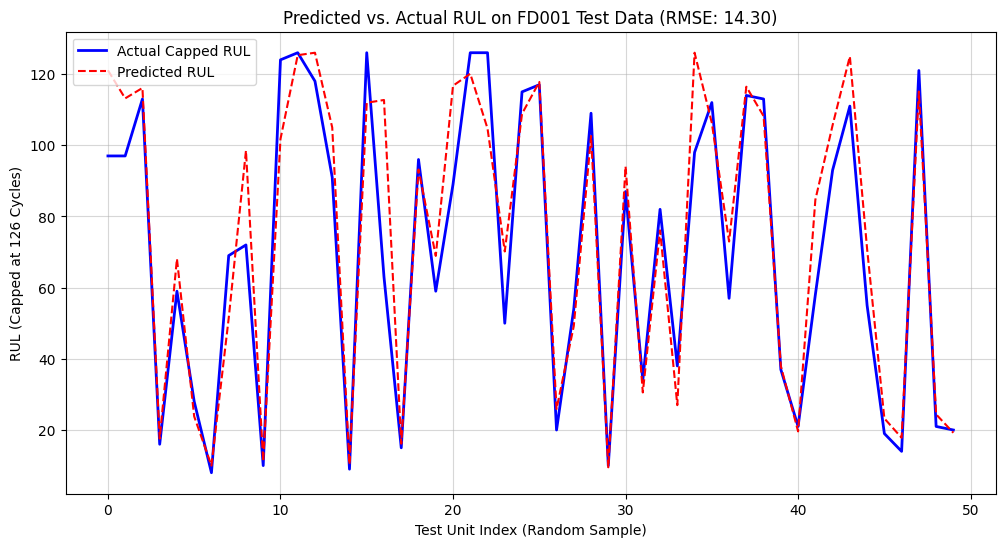


🚨 CRITICAL MAINTENANCE STATUS REPORT (Predicted RUL < 30 cycles)
|   Unit ID |   Predicted RUL |   True RUL | Status                           |
|----------:|----------------:|-----------:|:---------------------------------|
|        34 |            7.67 |          7 | CRITICAL (Immediate Maintenance) |
|        81 |            8.95 |          8 | CRITICAL (Immediate Maintenance) |
|        35 |            9.42 |         11 | CRITICAL (Immediate Maintenance) |
|        76 |            9.52 |         10 | CRITICAL (Immediate Maintenance) |
|        68 |           10    |          8 | CRITICAL (Immediate Maintenance) |
|        82 |           10.37 |          9 | WARNING (Monitor Closely)        |
|        31 |           10.88 |          8 | WARNING (Monitor Closely)        |
|        42 |           11.21 |         10 | WARNING (Monitor Closely)        |
|        56 |           16.17 |         15 | WARNING (Monitor Closely)        |
|        20 |           17.59 |         16 | WARNING (

In [8]:

# ------------------ EXECUTION ------------------
if __name__ == "__main__":
    DATASET = "FD001" 
    main_test_model(DATASET, DATA_PATH, MODEL_PATH, SEQ_LEN)


==================== Starting Testing for FD002 (30 cycles) ====================
Loading assets from D:/Spring_Board/PrognosAi/Models...
-> Test sequences generated: (259, 30, 24)
-> True RULs loaded: 259
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

🎉 Testing Complete for FD002.
-> Test RMSE (Capped RUL target): 20.2520 (Model's Performance)

📊 VISUALIZATION: Prediction vs. Actual (Capped RUL)


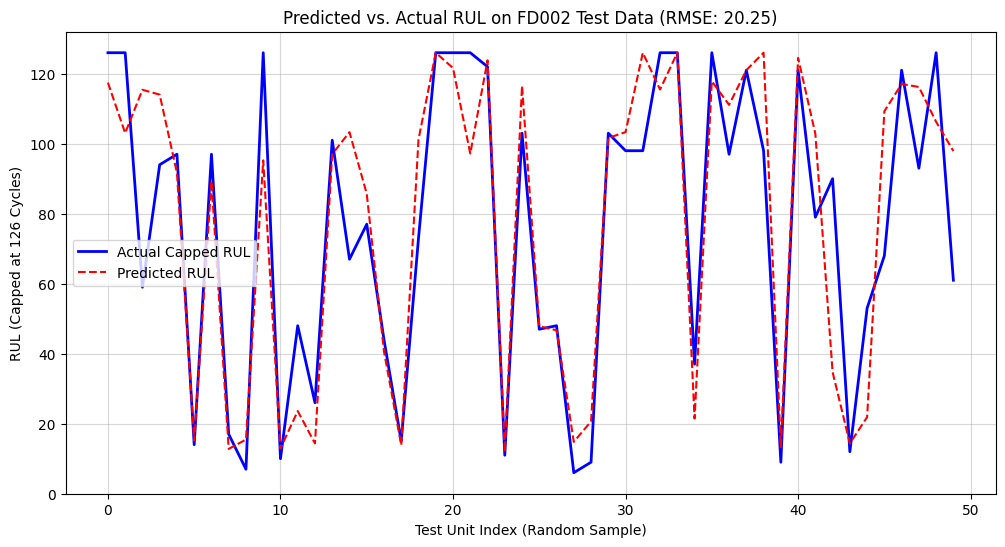


🚨 CRITICAL MAINTENANCE STATUS REPORT (Predicted RUL < 30 cycles)
|   Unit ID |   Predicted RUL |   True RUL | Status                           |
|----------:|----------------:|-----------:|:---------------------------------|
|        65 |            3.65 |         11 | CRITICAL (Immediate Maintenance) |
|       245 |            4.19 |         16 | CRITICAL (Immediate Maintenance) |
|       231 |            5.45 |          8 | CRITICAL (Immediate Maintenance) |
|         5 |            7.52 |         15 | CRITICAL (Immediate Maintenance) |
|       177 |            8.42 |          6 | CRITICAL (Immediate Maintenance) |
|       103 |            8.67 |          8 | CRITICAL (Immediate Maintenance) |
|        64 |            9.52 |         14 | CRITICAL (Immediate Maintenance) |
|        14 |            9.95 |         11 | CRITICAL (Immediate Maintenance) |
|       250 |           10.29 |         23 | WARNING (Monitor Closely)        |
|       100 |           10.59 |         14 | WARNING (

In [9]:
if __name__ == "__main__":
    DATASET = "FD002" 
    main_test_model(DATASET, DATA_PATH, MODEL_PATH, SEQ_LEN)


==================== Starting Testing for FD003 (30 cycles) ====================
Loading assets from D:/Spring_Board/PrognosAi/Models...
-> Test sequences generated: (100, 30, 20)
-> True RULs loaded: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

🎉 Testing Complete for FD003.
-> Test RMSE (Capped RUL target): 14.0374 (Model's Performance)

📊 VISUALIZATION: Prediction vs. Actual (Capped RUL)


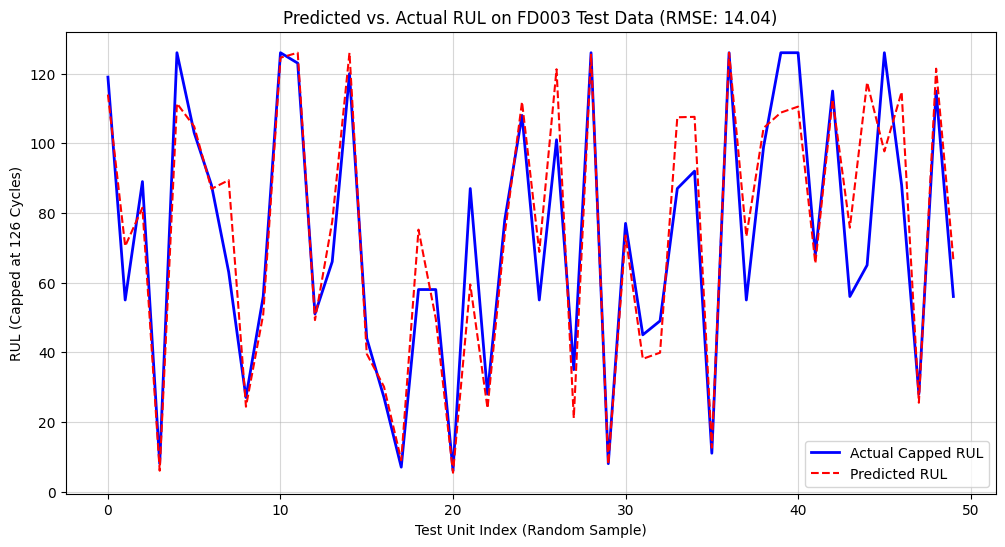


🚨 CRITICAL MAINTENANCE STATUS REPORT (Predicted RUL < 30 cycles)
|   Unit ID |   Predicted RUL |   True RUL | Status                           |
|----------:|----------------:|-----------:|:---------------------------------|
|        94 |            1.33 |         10 | CRITICAL (Immediate Maintenance) |
|        82 |            5.4  |          6 | CRITICAL (Immediate Maintenance) |
|        99 |            5.98 |          8 | CRITICAL (Immediate Maintenance) |
|        24 |            7.13 |          9 | CRITICAL (Immediate Maintenance) |
|        39 |            7.91 |          8 | CRITICAL (Immediate Maintenance) |
|        46 |            8.98 |          7 | CRITICAL (Immediate Maintenance) |
|        92 |           10.09 |         14 | WARNING (Monitor Closely)        |
|        26 |           12.6  |         11 | WARNING (Monitor Closely)        |
|        50 |           12.85 |         11 | WARNING (Monitor Closely)        |
|        98 |           13.06 |         17 | WARNING (

In [10]:
if __name__ == "__main__":
    DATASET = "FD003" 
    main_test_model(DATASET, DATA_PATH, MODEL_PATH, SEQ_LEN)


==================== Starting Testing for FD004 (30 cycles) ====================
Loading assets from D:/Spring_Board/PrognosAi/Models...
-> Test sequences generated: (248, 30, 24)
-> True RULs loaded: 248
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step

🎉 Testing Complete for FD004.
-> Test RMSE (Capped RUL target): 24.0709 (Model's Performance)

📊 VISUALIZATION: Prediction vs. Actual (Capped RUL)


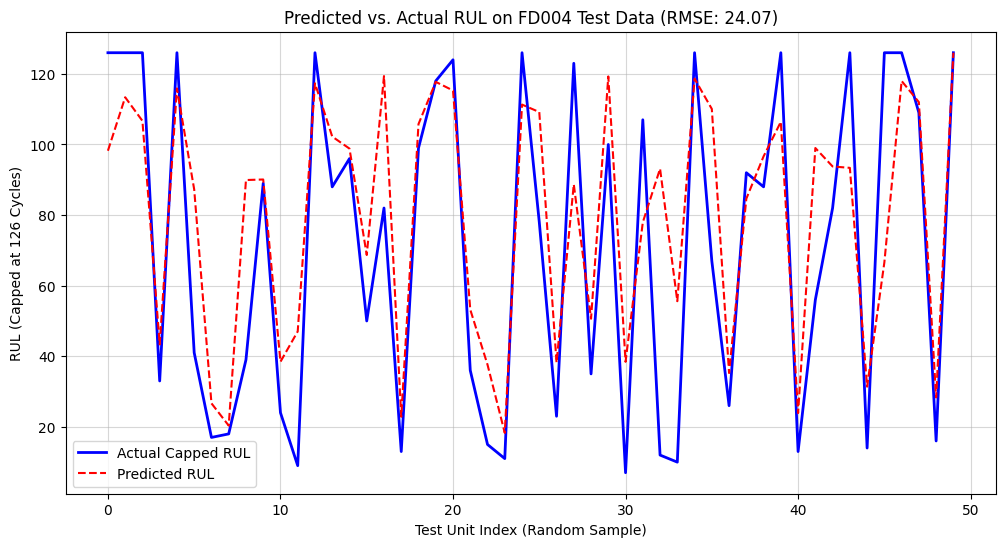


🚨 CRITICAL MAINTENANCE STATUS REPORT (Predicted RUL < 30 cycles)
|   Unit ID |   Predicted RUL |   True RUL | Status                    |
|----------:|----------------:|-----------:|:--------------------------|
|       135 |           16.24 |          7 | WARNING (Monitor Closely) |
|         8 |           18.09 |         14 | WARNING (Monitor Closely) |
|       102 |           18.18 |         22 | WARNING (Monitor Closely) |
|       198 |           18.28 |         11 | WARNING (Monitor Closely) |
|       184 |           18.77 |         10 | WARNING (Monitor Closely) |
|       158 |           19.74 |          6 | WARNING (Monitor Closely) |
|       100 |           19.95 |          7 | WARNING (Monitor Closely) |
|       118 |           20.04 |          8 | WARNING (Monitor Closely) |
|       237 |           20.35 |         18 | WARNING (Monitor Closely) |
|        65 |           21.06 |         12 | WARNING (Monitor Closely) |
|        71 |           21.09 |         15 | WARNING (Moni

In [11]:
if __name__ == "__main__":
    DATASET = "FD004" 
    main_test_model(DATASET, DATA_PATH, MODEL_PATH, SEQ_LEN)